# 멋진 챗봇 만들기

## BLEU Score

BLEU는 기계 번역된 테스트와 참조 번역 세트의 유사성을 측정하는 0과 1사이의 숫자. 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것(저품질)을 의미하고, 1이면 참조 번역과 완벽히 겹치는 것(고품질)을 의미한다. BLEU 점수는 사람이 번역 품질을 판단한 결과와 상관관계가 높은 것으로 확인되었다. 서로 다른 말뭉치 및 언어 간에는 BLEU 점수를 비교하지 않는 것이 좋다. 말뭉치는 동일하지만 참조 번역 수가 다른 BLEU 점수를 비교하는 것도 잘못된 해석으로 이어진다. 

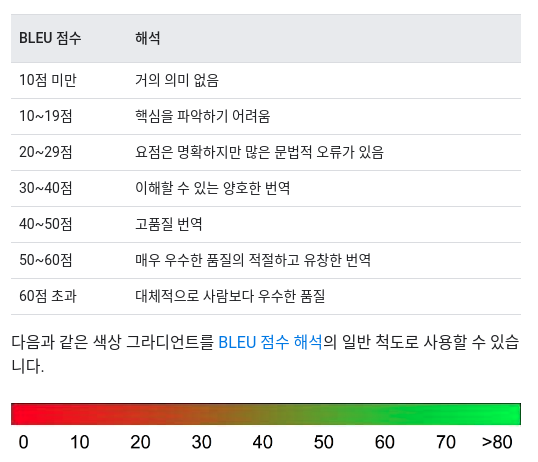

![](https://images.velog.io/images/guide333/post/fc9cead5-62a9-47ba-9323-34821df4554e/Screenshot%20from%202021-04-23%2012-44-10.png)

- $m^i_{cand}$: 참조 번역에 일치하는 후보 번역의 n-gram 수
- $m^i_{ref}$: 참조 번역의 n-gram 수
- $w^i_{t}$: 후보 번역의 n-gram 수

수식은 축약 패널티(Brevity Penalty)와 n-gram 중복이라는 두 부분으로 구성된다.
- 축약 패널티: 지수 감소를 근거로, 의미가 가장 가까운 참조 길이에 비해 지나치게 짧게 생성된 번역에 패널티를 적용한다. 
- n-gram 중복: 참조 번역에서 유니그램, 바이그램, ... 이 그에 해당하는 n-gram과 얼마나 일치하는지 측정한다. 

- 정리: https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

## 12. Project: 멋진 챗봇 만들기
지난 노드에서 챗봇과 번역기는 같은 집안이라고 했던 말을 기억하시나요?
앞서 배운 Seq2seq번역기와 Transfomer번역기에 적용할 수도 있겠지만, 이번 노드에서 배운 번역기 성능 측정법을 챗봇에도 적용해봅시다. 배운 지식을 다양하게 활용할 수 있는 것도 중요한 능력이겠죠. 이번 프로젝트를 통해서 챗봇과 번역기가 같은 집안인지 확인해보세요!

### Step 1. 데이터 다운로드
아래 링크에서 ChatbotData.csv 를 다운로드해 챗봇 훈련 데이터를 확보합니다. csv 파일을 읽는 데에는 pandas 라이브러리가 적합합니다. 읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

- [songys/Chatbot_data](https://github.com/songys/Chatbot_data)



In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import re
import os
import io
import time
import random
import urllib.request

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv", filename="ChatBotData.csv")
chatbot_data = pd.read_csv('ChatBotData.csv')
chatbot_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
print("챗봇 샘플의 개수: {}".format(len(chatbot_data)))

챗봇 샘플의 개수: 11823


In [4]:
print(chatbot_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [5]:
questions = chatbot_data['Q']
answers = chatbot_data['A']

questions.head()

0             12시 땡!
1        1지망 학교 떨어졌어
2       3박4일 놀러가고 싶다
3    3박4일 정도 놀러가고 싶다
4            PPL 심하네
Name: Q, dtype: object

In [6]:
answers.head()

0     하루가 또 가네요.
1      위로해 드립니다.
2    여행은 언제나 좋죠.
3    여행은 언제나 좋죠.
4     눈살이 찌푸려지죠.
Name: A, dtype: object

In [7]:
print(len(questions))
print(len(answers))

11823
11823


In [8]:
print(questions[2])

3박4일 놀러가고 싶다


### Step 2. 데이터 정제
아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

1. 영문자의 경우, 모두 소문자로 변환합니다.
2. 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!



In [9]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"[^a-zA-Z?.!,0-9^ㄱ-ㅎㅏ-ㅣ가-힣]+", " ", sentence)  # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

In [10]:
print(preprocess_sentence('12시 땡! '))

12시 땡!


### Step 3. 데이터 토큰화
토큰화에는 KoNLPy의 ```mecab``` 클래스를 사용합니다.

아래 조건을 만족하는 ```build_corpus()``` 함수를 구현하세요!

1. __소스 문장 데이터와 타겟 문장 데이터__ 를 입력으로 받습니다.
2. 데이터를 앞서 정의한 ```preprocess_sentence()``` 함수로 __정제하고, 토큰화__ 합니다.
3. 토큰화는 __전달받은 토크나이즈 함수__ 를 사용합니다. 이번엔 ```mecab.morphs``` 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. __중복되는 문장은 데이터에서 제외__ 합니다. ```소스 : 타겟 쌍```을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!


구현한 함수를 활용하여 ```questions``` 와 ```answers``` 를 각각 ```que_corpus``` , ```ans_corpus``` 에 토큰화하여 저장합니다.



In [11]:
from konlpy.tag import Mecab

def build_corpus(questions, answers):
    mecab = Mecab()
    que_corpus = []
    ans_corpus = []

    for i in range(len(questions)):
        que = preprocess_sentence(questions[i])
        ans = preprocess_sentence(answers[i])
        que_tokens = mecab.morphs(que)
        ans_tokens = mecab.morphs(ans)
        
        if (len(que_tokens) < 50) and (len(ans_tokens) < 50): 
            if que_tokens not in que_corpus:
                if ans_tokens not in ans_corpus:
                    que_corpus.append(que_tokens)
                    ans_corpus.append(ans_tokens)

    return que_corpus, ans_corpus

In [12]:
que_corpus, ans_corpus = build_corpus(questions, answers)

In [13]:
print(len(que_corpus))
print(len(ans_corpus))

7683
7683


In [14]:
que_corpus[:10]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '다']]

In [15]:
ans_corpus[:10]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.'],
 ['자랑', '하', '는', '자리', '니까요', '.'],
 ['그', '사람', '도', '그럴', '거', '예요', '.'],
 ['혼자', '를', '즐기', '세요', '.']]

### Step 4. Augmentation
우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다. 이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해봐야겠죠? __Lexical Substitution을 실제로 적용__해보도록 하겠습니다.

컴퓨터에 gensim이 설치되어 있지 않은 경우, 먼저 아래 명령어를 실행해 gensim 을 설치해 주세요. (4.0.1 버전의 경우, 한국어 word2vec을 불러오지 못하므로 아래의 버전으로 설치한다.)

```$ pip install gensim==3.8.2```

아래 링크를 참고하여 __한국어로 사전 훈련된 Embedding 모델을 다운로드__ 합니다. ```Korean (w)``` 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 ```Korean (w)```를 찾아 다운로드하고, ```ko.bin``` 파일을 얻으세요!

- [Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

다운로드한 모델을 활용해 __데이터를 Augmentation__ 하세요! 앞서 정의한 ```lexical_sub()``` 함수를 참고하면 도움이 많이 될 겁니다.

Augmentation된 ```que_corpus``` 와 원본 ```ans_corpus``` 가 병렬을 이루도록, 이후엔 반대로 원본 ```que_corpus``` 와 Augmentation된 ```ans_corpus``` 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [16]:
import gensim 
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [17]:
# 의미적 유사도 확인
word2vec.similar_by_word("바나나")

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('코코넛', 0.8097119927406311),
 ('시금치', 0.7701147794723511),
 ('레몬', 0.76884925365448),
 ('땅콩', 0.7684735059738159),
 ('파인애플', 0.7639915943145752),
 ('녹차', 0.7631459832191467),
 ('딸기', 0.7617197036743164),
 ('바닐라', 0.7497864961624146),
 ('파슬리', 0.7447543144226074),
 ('코코아', 0.7408244013786316)]

주어진 데이터를 토큰 단위로 분리한 후, 랜덤하게 하나를 선정하여 해당 토큰과 가장 유사한 단어를 찾아 대치하면 그것으로 Lexical Substitution은 완성된다.

In [26]:
import random

sample_sentence = "너 그거 알아? 너에게 필요한 것은 어텐션이라고!"
sample_tokens = sample_sentence.split()

selected_tok = random.choice(sample_tokens)

result = ""
for tok in sample_tokens:
    if tok is selected_tok:
        result += word2vec.similar_by_word(tok)[0][0] + " "

    else:
        result += tok + " "

print("From:", sample_sentence)
print("To:", result)

From: 너 그거 알아? 너에게 필요한 것은 어텐션이라고!
To: 너 뭐 알아? 너에게 필요한 것은 어텐션이라고! 


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # This is added back by InteractiveShellApp.init_path()


In [27]:
# Lexical Substitution 구현하기
def lexical_sub(sentence, word2vec):
    import random

    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [28]:
print(que_corpus[1])
print(lexical_sub(que_corpus[1], word2vec))

['1', '지망', '학교', '떨어졌', '어']
1 중퇴 학교 떨어졌 어 


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [29]:
from tqdm import tqdm_notebook

n_que_corpus = []
n_ans_corpus = []

for idx in tqdm_notebook(range(len(que_corpus))):
    ans = ans_corpus[idx]
    new_que = lexical_sub(que_corpus[idx], word2vec)
    if new_que is not None:
        new_que = new_que.split()
    else: continue

    n_que_corpus.append(new_que)
    n_ans_corpus.append(ans)

print(n_que_corpus[:10])

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7683 [00:00<?, ?it/s]

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


[['1', '지망', '학교', '떨어졌', '어서'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '으며'], ['sd', '단말기', '망가졌', '어'], ['sns', '맞', '팔', '과연', '안', '하', '지', 'ㅠㅠ'], ['sns', '시간', '낭비', '인', '거', '아', '으며', '매일', '하', '는', '중'], ['sns', '보', '면', '나의', '만', '빼', '고', '다', '행복', '해', '보여'], ['가끔', '궁금하', '해'], ['가끔', '은데', '혼자', '인', '게', '좋', '다'], ['부유', '한', '자', '의', '설움'], ['가만', '없', '어도', '땀', '난다']]


In [30]:
print(que_corpus[:10])

[['12', '시', '땡', '!'], ['1', '지망', '학교', '떨어졌', '어'], ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'], ['ppl', '심하', '네'], ['sd', '카드', '망가졌', '어'], ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'], ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'], ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'], ['가끔', '궁금', '해'], ['가끔', '은', '혼자', '인', '게', '좋', '다']]


In [31]:
print(len(n_que_corpus))

6569


In [32]:
for idx in tqdm_notebook(range(len(ans_corpus))):
    que = que_corpus[idx]
    new_ans = lexical_sub(ans_corpus[idx], word2vec)
    if new_ans is not None:
        new_ans = new_ans.split()
    else: continue

    n_que_corpus.append(que)
    n_ans_corpus.append(new_ans)

print(n_ans_corpus[100:110])

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/7683 [00:00<?, ?it/s]

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


[['계속', '좋', '지', '않', '으면', '병원', '에', '가', '보', '세요', '.'], ['타이밍', '이', '안', '맞', '았', '나', '봐요', '.'], ['이제', '취업', '하', '셔야죠', '.'], ['뇌세포', '에', '에너지', '를', '공급', '하', '려는', '자연', '스러운', '현상', '이', '에요', '.', '에너지', '가', '부족', '한가', '봐요', '.'], ['공부', '가', '최우선', '이', '죠', '.'], ['너무', '무리', '하', '지', '는', '마세요', '.'], ['저기압', '에', '는', '고기', '앞', '이', '죠', '.'], ['연습', '이', '필요', '해요', '.'], ['혼자', '가', '아니', '에요', '.'], ['인복', '이', '많', '나', '봐요', '.']]


In [33]:
print(ans_corpus[100:110])

[['결정', '은', '빠르', '면', '빠를수록', '좋', '을', '거', '예요', '.'], ['안타깝', '네요', '.', '증거', '를', '지금', '이', '라도', '모아', '봐요', '.'], ['좋', '겠', '어요', '.'], ['많이', '들', '지만', '줄일', '수', '있', '을', '거', '예요', '.'], ['경조사', '는', '참석', '하', '는', '게', '좋', '아요', '.'], ['생각', '보다', '신경', '안', '씁니다', '.'], ['인맥', '이', '넓', '으신가', '봐요', '.'], ['힘들', '겠', '네요', '.'], ['욕심', '에', '따라', '천지', '차이', '일', '거', '예요', '.'], ['허례허식', '이', '에요', '.']]


In [34]:
print(len(n_ans_corpus))

13323


In [35]:
que_corpus = que_corpus + n_que_corpus
ans_corpus = ans_corpus + n_ans_corpus

In [36]:
print(len(que_corpus))
print(len(ans_corpus))

21006
21006


In [37]:
que_corpus[20400]

['전', '너무', '이기', '적', '인데', '저', '를', '좋아해', '줘요', '.']

In [38]:
ans_corpus[20400]

['그대로', '사랑', '해의', '줄', '사람', '이', '나타났나', '봅니다', '.']

### Step 5. 데이터 벡터화
타겟 데이터인 ```ans_corpus``` 에 ```<start>``` 토큰과 ```<end>``` 토큰이 추가되지 않은 상태이니 이를 먼저 해결한 후 벡터화를 진행합니다. 우리가 구축한 ```ans_corpus``` 는 ```list``` 형태이기 때문에 아주 쉽게 이를 해결할 수 있답니다!

In [39]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


1. 위 소스를 참고하여 타겟 데이터 전체에 ```<start>``` 토큰과 ```<end>``` 토큰을 추가해 주세요!

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 __소스 데이터와 타겟 데이터가 같은 언어를 사용__ 한다는 것이겠죠. 앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.

1. 특수 토큰을 더함으로써 ```ans_corpus``` 또한 완성이 되었으니, ```que_corpus``` 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 ```enc_train``` 과 ```dec_train``` 을 얻으세요!

- 특수 토큰 더하기

In [40]:
new_ans = []

for corpus in ans_corpus:
        new_ans.append(["<start>"] + corpus + ["<end>"])
    
ans_corpus = new_ans

In [41]:
print(ans_corpus[0])

['<start>', '하루', '가', '또', '가', '네요', '.', '<end>']


- 단어장 구축    
[GD-L3]word_embedding 참고

In [42]:
from collections import Counter

corpus = que_corpus + ans_corpus

words = np.concatenate(corpus).tolist()


In [43]:
print(words[:10])
print(len(words))

['12', '시', '땡', '!', '1', '지망', '학교', '떨어졌', '어', '3']
384807


In [47]:
vocab = Counter(words)
vocab = vocab.most_common(20000-2)
print(vocab[:10])

[('.', 24585), ('<start>', 21006), ('<end>', 21006), ('이', 9472), ('는', 9063), ('하', 8877), ('을', 5666), ('가', 4969), ('좋', 4477), ('고', 4330)]


In [48]:
vocab = ['<PAD>', '<UNK>'] + [key for key, _ in vocab]
vocab[:10]

['<PAD>', '<UNK>', '.', '<start>', '<end>', '이', '는', '하', '을', '가']

In [49]:
word2idx = {word:index for index, word in enumerate(vocab)} 
idx2word = {index: word for word, index in word2idx.items()}

In [50]:
idx2word

{0: '<PAD>',
 1: '<UNK>',
 2: '.',
 3: '<start>',
 4: '<end>',
 5: '이',
 6: '는',
 7: '하',
 8: '을',
 9: '가',
 10: '좋',
 11: '고',
 12: '세요',
 13: '어',
 14: '거',
 15: '있',
 16: '은',
 17: '해',
 18: '보',
 19: '지',
 20: '?',
 21: '아',
 22: '도',
 23: '나',
 24: '게',
 25: '는데',
 26: '겠',
 27: '에',
 28: '사람',
 29: '예요',
 30: '사랑',
 31: '어요',
 32: '를',
 33: '같',
 34: '죠',
 35: '한',
 36: '것',
 37: '없',
 38: '다',
 39: '수',
 40: '싶',
 41: '면',
 42: '네',
 43: '네요',
 44: '의',
 45: '안',
 46: '친구',
 47: '생각',
 48: '않',
 49: '아요',
 50: '봐요',
 51: '말',
 52: '마음',
 53: '할',
 54: '너무',
 55: '되',
 56: '주',
 57: '잘',
 58: '남자',
 59: '이별',
 60: '했',
 61: '내',
 62: '었',
 63: '더',
 64: '기',
 65: '연락',
 66: '만',
 67: '여자',
 68: '들',
 69: '일',
 70: '힘들',
 71: '남',
 72: '해요',
 73: '썸',
 74: '시간',
 75: '짝',
 76: '많이',
 77: '으로',
 78: '한테',
 79: '길',
 80: '았',
 81: '으면',
 82: '괜찮',
 83: '에요',
 84: '건',
 85: '에서',
 86: '때',
 87: '좀',
 88: '알',
 89: '요',
 90: '만나',
 91: '그',
 92: '야',
 93: '에게',
 94: '많',
 95: '저',
 96

In [51]:
print([word2idx[word] if word in word2idx else word2idx['<unk>'] for word in ['12', '시', '땡', '!', '1', '지망', '학교', '떨어졌', '어', '3']])

[3181, 228, 3182, 116, 301, 3810, 604, 1096, 13, 308]


In [52]:
print(que_corpus[:2])

[['12', '시', '땡', '!'], ['1', '지망', '학교', '떨어졌', '어']]


- 벡터화

In [53]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한 번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [54]:
new_que_corpus = []
for sen in que_corpus:
    que = get_encoded_sentence(sen, word2idx)
    new_que_corpus.append(que)

In [55]:
new_que_corpus[:10]

[[3181, 228, 3182, 116],
 [301, 3810, 604, 1096, 13],
 [308, 2347, 517, 69, 278, 274, 9, 11, 40, 38],
 [5597, 1197, 42],
 [3811, 1809, 3812, 13],
 [583, 203, 1198, 136, 45, 7, 19, 689],
 [583, 74, 1568, 102, 14, 21, 25, 449, 7, 6, 158],
 [583, 18, 41, 23, 66, 1231, 11, 38, 162, 17, 561],
 [514, 356, 17],
 [514, 16, 185, 102, 24, 10, 38]]

In [56]:
new_ans_corpus = []
for sen in ans_corpus:
    ans = get_encoded_sentence(sen, word2idx)
    new_ans_corpus.append(ans)

In [57]:
new_ans_corpus[:10]

[[3, 281, 9, 147, 9, 43, 2, 4],
 [3, 636, 17, 1419, 2, 4],
 [3, 291, 16, 612, 10, 34, 2, 4],
 [3, 6253, 5, 6254, 19, 34, 2, 4],
 [3, 126, 2121, 193, 6, 24, 52, 4897, 2, 4],
 [3, 57, 114, 11, 15, 8, 39, 22, 15, 31, 2, 4],
 [3, 74, 8, 2296, 11, 17, 18, 12, 2, 4],
 [3, 3303, 7, 6, 857, 266, 2, 4],
 [3, 91, 28, 22, 225, 14, 29, 2, 4],
 [3, 185, 32, 973, 12, 2, 4]]

In [58]:
print(len(new_que_corpus))
print(len(new_que_corpus))

21006
21006


In [59]:
print(new_que_corpus[:10])

[[3181, 228, 3182, 116], [301, 3810, 604, 1096, 13], [308, 2347, 517, 69, 278, 274, 9, 11, 40, 38], [5597, 1197, 42], [3811, 1809, 3812, 13], [583, 203, 1198, 136, 45, 7, 19, 689], [583, 74, 1568, 102, 14, 21, 25, 449, 7, 6, 158], [583, 18, 41, 23, 66, 1231, 11, 38, 162, 17, 561], [514, 356, 17], [514, 16, 185, 102, 24, 10, 38]]


In [60]:
print(new_ans_corpus[:10])

[[3, 281, 9, 147, 9, 43, 2, 4], [3, 636, 17, 1419, 2, 4], [3, 291, 16, 612, 10, 34, 2, 4], [3, 6253, 5, 6254, 19, 34, 2, 4], [3, 126, 2121, 193, 6, 24, 52, 4897, 2, 4], [3, 57, 114, 11, 15, 8, 39, 22, 15, 31, 2, 4], [3, 74, 8, 2296, 11, 17, 18, 12, 2, 4], [3, 3303, 7, 6, 857, 266, 2, 4], [3, 91, 28, 22, 225, 14, 29, 2, 4], [3, 185, 32, 973, 12, 2, 4]]


- 데이터 나누기

In [61]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(new_que_corpus, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(new_ans_corpus, padding='post')

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01)

print("enc_train :", len(enc_train), "enc_val :", len(enc_val))
print("dec_train :", len(dec_train), "dec_val :",len(dec_val))

enc_train : 20795 enc_val : 211
dec_train : 20795 dec_val : 211


In [62]:
enc_train[0]

array([ 110,  294,   90,    6,   36,   22, 1518,   42,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [63]:
dec_train[0]

array([  3, 305, 414,  16, 612, 831,  36,  33,  49,   2,   4,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

### Step 6. 훈련하기
앞서 번역 모델을 훈련하며 정의한 ```Transformer``` 를 그대로 사용하시면 됩니다! 대신 데이터의 크기가 작으니 하이퍼파라미터를 튜닝해야 과적합을 피할 수 있습니다. 모델을 훈련하고 아래 예문에 대한 답변을 생성하세요! __가장 멋진 답변과 모델의 하이퍼파라미터를 제출__ 하시면 됩니다.

```python
# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>

Hyperparameters
> n_layers: 1
> d_model: 368
> n_heads: 8
> d_ff: 1024
> dropout: 0.2

Training Parameters
> Warmup Steps: 1000
> Batch Size: 64
> Epoch At: 10
```

- transformer 만들기

In [64]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # 인덱스가 짝수
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # 인덱스가 홀수

             
    return sinusoid_table

In [65]:
# Mask  생성하기
def generate_padding_mask(seq):
    # tf.math.equal: seq의 원소가 0이 되면 true로 반환, 아니면 false 반환
    # tf.cast: true를 float32로 변환
    
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]    # np.newaxis: numpy array의 차원 늘려주기

def generate_causality_mask(src_len, tgt_len):
    # np.cumsum(): 배열에서 행에 따라 누적되는 원소들의 누적합 계산
    # np.eye(): 대각선이 1인 seq_len x seq_len 크기의 대각행렬 생성
    
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)  # tf.cast: mask(텐서)를 float32로 변환


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [66]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads
        
        # Linear Layer
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)   #  Scaled QK

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)   # Attention Weights
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ] - tf.reshape으로 만듬
        """

        bsz = x.shape[0]  # batch size
        # reshape - shape의 한 원소만 -1, 의미는 전체 크기가 일정하게 유지되도록 해당 차원의 길이가 자동으로 계산
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])   #  perm은 치환하는 위치를 알려줌

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        # Linear 레이어 추가 - embedding 매핑
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [67]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [68]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [69]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [70]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [71]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [72]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,  # 레이어의 차원수
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
            

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        # np.newaxis: numpy array의 차원 늘려주기
        
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
            
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [73]:
n_layers = 1
d_model = 368
n_heads = 8
d_ff = 1024
dropout = 0.2

In [74]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
VOCAB_SIZE = 20000

transformer = Transformer(
    n_layers= n_layers,
    d_model = d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=dropout,
    shared_fc=True,
    shared_emb=True)


In [75]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [76]:
# Learning Rate 인스턴스 선언 & Optimizer 구현
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)


In [77]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


In [78]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [79]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, idx2word):
    return ' '.join(idx2word[index] if index in idx2word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한 번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, idx2word):
    return [get_decoded_sentence(encoded_sentence, idx2word) for encoded_sentence in encoded_sentences]

In [83]:
# translate()

def evaluate(sentence, model):
    # sentence 전처리(enc_train과 같은 모양으로)
    mecab = Mecab()
    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)

    tokens = get_encoded_sentence(pieces, word2idx)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    
    output = tf.expand_dims([word2idx["<start>"]], 0) # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장
    
    # 디코더 인퍼런스 단계
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        
        # 예측 단어가 종료 토큰일 경우
        if word2idx["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, idx2word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, idx2word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    return result

In [84]:
examples = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야."
]

In [85]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        

    print("Translations")   
    for example in examples:
        translate(example, transformer)
        
    print()
    print("Hyperparameters")
    print("n_layers:", n_layers)
    print("n_heads:", n_heads)
    print("d_ff:", d_ff)
    print("dropout:", dropout)
    print()
    print("Training Parameters")
    print("Warmup steps: 1000")
    print("Batch Size:", BATCH_SIZE)
    print("Epoch At:", epoch+1)        
    

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 은 사람 은 사람 이 있 을 거 예요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 하 지 않 을 거 예요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 은 사람 이 있 는 건 어떨까 요 .
Input: 집에 있는다는 소리야.
Predicted translation: 하 는 게 되 고 있 을 거 예요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 1


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 은 것 도 좋 아요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 한 잔 해 보 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 은 곳 적 인 곳 으로 좋 을 거 예요 .
Input: 집에 있는다는 소리야.
Predicted translation: 이 되 지 않 아요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 2


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 은 언제나 좋 겠 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 에 좋 은 날 이 에요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 은 자유 신경 쓰이 는 편 이 좋 겠 네요 .
Input: 집에 있는다는 소리야.
Predicted translation: 더 연습 해 보 세요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 3


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 도 좋 겠 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 한잔 한잔 한잔 한잔 이 에요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 는 자유 한 곳 으로 자유 서 자유 지나 라고 생각 해요 .
Input: 집에 있는다는 소리야.
Predicted translation: 에 는 것 같 아요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 4


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 조금 만 조금 놀 아요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 주무세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 능력 이 서 그럴 했 나 봐요 .
Input: 집에 있는다는 소리야.
Predicted translation: 로 먹 고 되 면 돼요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 5


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 가 좋 겠 네요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 에게 한 만남 이 에요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 도 그럴 때 가 좋 겠 죠 .
Input: 집에 있는다는 소리야.
Predicted translation: 로 안 되 면 안 되 지 않 죠 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 6


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 후회 가 좋 겠 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 이 최고 죠 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 위한 시작 하 기 도 해요 . 차분히 생각 해 보 세요 .
Input: 집에 있는다는 소리야.
Predicted translation: 은 친구 를 가지 보 세요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 7


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 조금 만 조금 만 조금 만 괜찮 아요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 이 날 이 예요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 수 도 있 어요 .
Input: 집에 있는다는 소리야.
Predicted translation: 로 청소기 는 데 는 모든 데이트 는 건 어떨까 요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 8


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 만 더 차분 하 게 좋 겠 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 일어날 흔적 이 네요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 중요 한 건 아닌지 확인 하 지 마세요 .
Input: 집에 있는다는 소리야.
Predicted translation: 이 되 었 나 봐요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 9


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 처럼 인가요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 도 집착 하 는 데이트 도 좋 해요 .
Input: 집에 있는다는 소리야.
Predicted translation: 만 보 고 싶 네요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 10


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 쉬 었 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 주무세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 소중 해요 .
Input: 집에 있는다는 소리야.
Predicted translation: 시간 이 되 는 게 되 겠 죠 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 11


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 새 출발 하 게 될 거 예요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 이 힘 이 들 었 나 봐요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 도 충분히 잘 때때 거 예요 .
Input: 집에 있는다는 소리야.
Predicted translation: 만 의 날 이 있 죠 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 12


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 쉬 고 있 나 봐요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 만 짐 을 드세요
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 그럴 때 도 있 어요 .
Input: 집에 있는다는 소리야.
Predicted translation: 만 에 도 그럴 거 예요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 13


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 해 보 면 좋 을 거 같 아요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 고 싶 나 봐요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 약간 의 데이트 가 없 어요 .
Input: 집에 있는다는 소리야.
Predicted translation: 마요 . 같이 라면 무엇 이 되 겠 죠 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 14


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 조금 씩 버려 보 세요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 처럼 잘 선택 하 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 힘 을 내리 는 데이트 를 할 거 예요 .
Input: 집에 있는다는 소리야.
Predicted translation: 들 을 가지 고 있 나 봐요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 15


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 조금 씩 버려 보 세요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 쉬 세요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 집착 하 는 추억 도 좋 을 거 예요 .
Input: 집에 있는다는 소리야.
Predicted translation: 고 나가 는 걸 하 지 마세요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 16


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 지냈 으면 좋 겠 어요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 쉬 는 건 어떨까 요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 매일 그럴 수 도 있 어요 .
Input: 집에 있는다는 소리야.
Predicted translation: 마요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 17


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 애매 하 게 될 거 예요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 마다 할 수 있 는 존재 에 같 아요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 을 위한 최선 적 인 거 같 아요 .
Input: 집에 있는다는 소리야.
Predicted translation: 중요 하 지 않 아요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 18


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 지냈 나 봐요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 이 나 봐요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 한 대화 를 나눠 보 세요 .
Input: 집에 있는다는 소리야.
Predicted translation: 을 따져 보 세요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 19


  0%|          | 0/325 [00:00<?, ?it/s]

Translations
Input: 지루하다, 놀러가고 싶어.
Predicted translation: 이 좀 무엇 을 거 예요 .
Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 돌아가 에서 될 거 예요 .
Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: . 으로 생각 하 지 마세요
Input: 집에 있는다는 소리야.
Predicted translation: 이 가장 보 세요 .

Hyperparameters
n_layers: 1
n_heads: 8
d_ff: 1024
dropout: 0.2

Training Parameters
Warmup steps: 1000
Batch Size: 64
Epoch At: 20


### Step 7. 성능 측정하기
챗봇의 경우, 올바른 대답을 하는지가 중요한 평가지표입니다. 올바른 답변을 하는지 눈으로 확인할 수 있겠지만, 많은 데이터의 경우는 모든 결과를 확인할 수 없을 것입니다. 주어잔 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 ```calculate_bleu()``` 함수도 적용해보세요.

In [86]:
translate("커피는 필요 없어.", transformer)

Input: 커피는 필요 없어.
Predicted translation: 는 향 에 있 어요 .


'는 향 에 있 어요 .'

In [87]:
translate("비가 와서 몸이 늘어져", transformer)

Input: 비가 와서 몸이 늘어져
Predicted translation: 이 좀 더 답니다 .


'이 좀 더 답니다 .'

In [88]:
translate("배고파", transformer)

Input: 배고파
Predicted translation: 맛난 음식 드세요 .


'맛난 음식 드세요 .'

NLTK가 BLEU Score를 지원하므로 이를 활용한다.

In [89]:
from nltk.translate.bleu_score import sentence_bleu

reference = "많 은 자연어 처리 연구자 들 이 트랜스포머 를 선호 한다".split()
candidate = "적 은 자연어 학 개발자 들 가 트랜스포머 을 선호 한다 요".split()

print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: ['많', '은', '자연어', '처리', '연구자', '들', '이', '트랜스포머', '를', '선호', '한다']
번역문: ['적', '은', '자연어', '학', '개발자', '들', '가', '트랜스포머', '을', '선호', '한다', '요']
BLEU Score: 8.190757052088229e-155


/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU 계산시 특정 N-gram이 0점이 나와서 BLEU가 너무 커지거나 작아지는 쪽으로 왜곡되는 문제를 보완하기 위해 SmoothingFunction() 을 사용한다. Smoothing 함수는 모든 Precision에 아주 작은 epsilon 값을 더해주어 0점이 부여된 Precision도 완전한 0이 되지 않게 한다. 따라서 점수를 1.0 으로 대체할 필요가 없어진다.

nltk에서는 method0부터 method7까지를 이미 제공한다.

In [90]:
from nltk.translate.bleu_score import SmoothingFunction

def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.5
BLEU-2: 0.18181818181818182
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.05637560315259291


In [91]:
def eval_bleu(src_corpus, tgt_corpus, verbose=True):
    total_score = 0.0
    sample_size = len(tgt_corpus)

    for idx in tqdm_notebook(range(sample_size)):
        src_tokens = src_corpus[idx]
        tgt_tokens = tgt_corpus[idx]
        
        src = []
        tgt = []
        
        for word in src_tokens:
            if word !=0 and word !=1 and word !=3 and word !=4:
                src.append(word)
        
        for word in tgt_tokens:
            if word != 0 and word != 3 and word !=4:
                tgt.append(word)

        src_sentence = get_decoded_sentence(src, idx2word)
        tgt_sentence = get_decoded_sentence(tgt, idx2word)
        
        
        reference = preprocess_sentence(tgt_sentence).split()
        candidate = translate(src_sentence, transformer).split()

        score = sentence_bleu([reference], candidate,
                              smoothing_function=SmoothingFunction().method1)
        total_score += score

        if verbose:
            print("Source Sentence: ", src_sentence)
            print("Model Prediction: ", candidate)
            print("Real: ", reference)
            print("Score: %lf\n" % score)

    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)




In [92]:
eval_bleu(enc_val[::10], dec_val[::10], verbose=True)

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/22 [00:00<?, ?it/s]

Input: 년 째 연애 하 고 있 어
Predicted translation: 시간 이 후련 하 겠 어요 .
Source Sentence:  년 째 연애 하 고 있 어
Model Prediction:  ['시간', '이', '후련', '하', '겠', '어요', '.']
Real:  ['은', '기억', '들', '그러', '많', '겠', '네요', '.']
Score: 0.034052

Input: 많이 가리 는 남자 를 사 겨 도 괜찮 을까 ?
Predicted translation: 다시 연락 하 고 싶 은 다시 만날 수 있 을 거 예요 .
Source Sentence:  많이 가리 는 남자 를 사 겨 도 괜찮 을까 ?
Model Prediction:  ['다시', '연락', '하', '고', '싶', '은', '다시', '만날', '수', '있', '을', '거', '예요', '.']
Real:  ['먹', '으면', '좋', '겠', '지만', '큰', '문제점', '는', '되', '지', '않', '을', '거', '예요', '.']
Score: 0.165528

Input: 는 그냥저냥 사 는 거 같 아
Predicted translation: 누구 나 약간 씩 변화 을 해 보 세요 .
Source Sentence:  는 그냥저냥 사 는 거 같 아
Model Prediction:  ['누구', '나', '약간', '씩', '변화', '을', '해', '보', '세요', '.']
Real:  ['은', '약간', '의', '변화', '를', '줘', '보', '세요', '.']
Score: 0.118684

Input: 아 하 는 남자 애 가 바람둥이 같 은데 계속 좋 아 시키 면 안 되 겠 죠 ?
Predicted translation: 마다 너무 신경 쓰 지 마세요 .
Source Sentence:  아 하 는 남자 애 가 바람둥이 같 은데 계속 좋 아 시키 면 안 되 겠 죠 ?
Model Prediction:  ['마다', '너무', '신

### 결과
트랜스포머를 돌린 결과가 좋지 않다. 또한 BLEU score도 9점으로 낮다. 모델의 문제인지, 아니면 BLEU score 함수를 잘못 설정해서인지는 잘 모르겠다.

### 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

|평가문항|	상세기준||
|:------:|:--------:|:--------:|
|1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?|챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.|Y|
|2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?|과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.|Y|
|3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?|주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.| Y|













## 후기
### 이번 프로젝트에서 어려웠던 점
- data augmentation, 단어장 만들기, 벡터화, BLEU 스코어 함수 짜기 등 여러 부분이 어려웠다. 여러 자료를 찾아보고 도움을 받아 해결할 수 있었다.
- gensim 버전 문제: 텐서 플로우 버전 때문에 실행되지 않는지 알았더니 gensim 버전이 높아서 실행이 되지 않는 것이었다. 

### 프로젝트를 진행하면서 알게된 점
-  텍스트 데이터 증식의 개념
- BLEU score

### 프로젝트를 진행하면서 아직 모호한 점
- Evaluation 함수
- BLEU score 함수: BLEU score 함수를 통한 실제 문장과 예측 문장이 제대로 나오지 않은 것 보니 뭔가 잘못된 것 같다. 

### 자기 다짐
이번 프로젝트는 완성하지 못할 뻔 했다. 기존 했던 프로젝트를 찾아보면서 해결할 수 있었다. 그러나 제대로 한 것인지는 잘 모르겠다. 코드를 찍어서 모양을 맞추고 비슷한 코드를 갖다 쓴 것이기 때문이다. Evaluation과 BLEU score 함수 부분에서 특히 많이 헤맸고, 지금도 제대로 된 것인지는 잘 모르겠다. 

고잉디퍼도 끝났지만 아직 자연어 처리에 대해 명확하게 잡힌 것이 없다. 프로젝트를 하면서도 뭘 해야 하는지, 어떤 것을 갖다 써야 하는지 몰라서 한참을 헤맸다. 이전에 했던 것들을 복습하면서 계속 익혀야 할 것 같다.